# Preconfiguring the IDE (Предварительная настройка среды разработки)

Подключим Google Drive:

In [ ]:
# Подключим диск Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключим Google data_table для удобства отображения датафреймов:

In [ ]:
from google.colab import data_table

Разрешим использование сторонних виджетов в Collab (ноебходимо для CatBoost):

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

# Необохдимо для нормальной визуализации Catboost в Jupiter
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Разархивируем файлы датасета:

In [ ]:
!unzip /content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_1/Homework_4/DATASET/Credit_Card_Customers.zip -d /content/

Archive:  /content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_1/Homework_4/DATASET/Credit_Card_Customers.zip
  inflating: /content/BankChurners.csv  


Установим дополнительные бибилиотеки в среду разработки:

In [ ]:
!pip install ipython-autotime
!pip install missingno
!pip install catboost

Настроим вывод времени выполнения для каждой ячейки с помощью `ipython-autotime`:

In [ ]:
%load_ext autotime

time: 0 ns (started: 2022-10-18 17:37:35 +03:00)


Отключим вывод сообщений о будущих ошибках:

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

time: 0 ns (started: 2022-10-18 17:41:17 +03:00)


Загрузим необходимые бибилеотеки:

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno


from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier, Pool


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")


import os
import chardet
import gc

time: 1.03 s (started: 2022-10-18 17:37:35 +03:00)


Определим дополнительные функции:

In [ ]:
def get_files_charset(directory='./', extensions=('.csv'), chunk_size_bytes=30000):
  
  # result storage
  row_index = []
  row = {"Full file path": [], "File size (MB)": [], "Possible encoding": [], "Possible language": [], "Confidence %": []}

  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(tuple(extensions)):

        # Получим полный путь к файлу
        full_path = os.path.join(root, file)

        # Получим размер в мегабайтах
        file_size_mb = round(((os.path.getsize(full_path))/(1024*1024)),2)


        with open(full_path, 'rb') as rawdata:
          result = chardet.detect(rawdata.read(chunk_size_bytes))

        row_index.append(file)

        row["Full file path"].append(full_path)
        row["File size (MB)"].append(file_size_mb)
        row["Possible encoding"].append(result['encoding'])
        row["Possible language"].append(result['language'])
        row["Confidence %"].append(result['confidence'] * 100)

    
    result = pd.DataFrame(row, index=row_index)
    result.index.name = 'File name'

    return result

# Функция для проверки категориальных данных датафрейма.
def show_category_values(df, categorical_columns=[]):

  row_index = []
  row = {'Category names' : [], 'Category count':[]}

  if not categorical_columns:
    categorical_columns = df.select_dtypes(include=["category"])
  
  for column in categorical_columns:
    row_index.append(column)
    row["Category names"].append(str(sorted(df[column].unique())))
    row["Category count"].append(df[column].nunique())

  result = pd.DataFrame(row, index=row_index)
  result.index.name = 'Column name'

  return(result)

# Функция формирующая отчет по отсутсвующим значениям
def show_missing_values_report(df):

  # Найдём общие показатели 
  
  # Общее число значений в датафрейме
  df_total_cells = np.product(df.shape)

  # Всего, кол-во и процент NaN
  df_total_na = df.isna().sum().sum()
  df_total_is_na_proc = df_total_na * 100 / df_total_cells

  result = pd.DataFrame(columns = ['NaN count', 'NaN %'])
  result.index.name = 'Column name'

  result['NaN count'] = df.isna().sum()

  # Процент от общего числа элементов в датафрейме.
  result['NaN %'] = np.around((result['NaN count'] * 100 / df.shape[0]),4)

  result.loc['TOTAL'] = {'NaN count': result['NaN count'].sum(),
                         'NaN %': np.around(df_total_is_na_proc, decimals=4)}
  
  return result


def check_columns_boundaries(df, numeric_columns_names):
  """ """
  row_index = []
  row = {"Minimum" : [], "Maximum":[]}

  if not numeric_columns_names:
    numeric_columns_names = df.select_dtypes(include=[np.number])

  for name in numeric_columns_names:
    row_index.append(name)

    row["Minimum"].append(df[name].dropna().min())
    row["Maximum"].append(df[name].dropna().max())

  result = pd.DataFrame(row, index=row_index)
  result.index.name = 'Column name'

  return result


time: 0 ns (started: 2022-10-18 17:37:36 +03:00)


Функции из мини-курса Kaggle:

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Полезные функции из учебника Kaggle "Feature Engineering"
# Функция расчёта метрики полезности информации
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

time: 0 ns (started: 2022-10-18 17:37:37 +03:00)


# Problem Definition (Описание проблемы)

## Задание

Необходимо предсказывать отток (Attrition_Flag) пользователей кредитных карт на основе данных

Попробуйте использовать перебор моделей adaboost и gradient boosting. Учтите дисбаланс классов.

## About Dataset (О датасете)

Менеджер в банке обеспокоен тем, что все больше и больше клиентов перестают пользоваться их кредитными картами. Они были бы очень признательны, если бы кто-нибудь мог предсказать, кто из клиентов вскоре откажется от кредитной карты, чтобы они могли заблаговременно обратиться к клиенту, чтобы предоставить ему боллее лучшие услуги и повлиять на решение клиента.

Сейчас этот набор данных состоит из информации о 10 000 клиентов с указанием их возраста, зарплаты, семейного статуса, лимита по кредитной карты, категории кредитной карты и т.д. Это почти 18 признаков.

У нас есть только 16,07% клиентов, которые начали пользоваться другой кридитной картой. Таким образом, немного сложно обучить нашу модель для прогнозирования оттока клиентов.

Датасет состоит из следующих признаков:    
- `CLIENTNUM` - [Целочисленное] Номер клиента. Уникальный идентификатор клиента, владеющего счетом.    

- `Attrition_Flag` - [Категория] (ЦЕЛЕВОЙ ПАРАМЕТР) Переменная внутреннего события (активность клиента):    
  - "Existing Customer" [0] - действующий клиент,
  - "Attrited Customer" [1] - отказавшийся клиент.    

- `Customer_Age` - [Целочисленное] Демографическая переменная, возраст клиента в годах.     

- `Gender` - [Категория] Демографическая переменная, пол:    
  - `M` - мужчина,    
  - `F` - женщина.    

- `Dependent_count` - [Целочисленное] Демографическая переменная, количество иждивенцев.     

- `Education_Level` - [Категория] Демографическая переменная, уровень образование владельца счета:    
  - `Graduate` - студент магистратуры,
  - `College` - студент бакалавриата, 
  - `Doctorate` - докторская степень, 
  - `High School` - студент специалитета,
  - `Post-Graduate` - послевузовское профессиональное образование, 
  - `Uneducated` - нет образования, 
  - `Unknown` - неизвестно,
  - `Other` - другое.

- `Marital_Status` - [Категория] Демографическая переменная, семейный статус:
  - `Divorced` - разведенн, 
  - `Married` - женатый/замужем, 
  - `Single` - одинокий, 
  - `Unknown` - неизвестно

- `Income_Category` - [Категория] Демографическая переменная, категория годового дохода владельца счета:
  - `120K +` - более 120K,    
  - `80K - 120K` - от 80K - 120K,    
  - `60K - 80K` - от 60K - 80K,    
  - `40K - 60K` - от 40K - 60K,    
  - `Less than 40K` - менее 40K,     
  - `Unknown` - неизвестно.     

- `Card_Category` - [Категория] - Тип карты:
  - `Blue` - голубая, 
  - `Silver` - серебрянная,
  - `Gold` - золотая,
  - `Platinum` - платиновая.    

- `Months_on_book` - [Целочисленное] Период взаимоотношений с банком.    

- `Total_Relationship_Count` - [Целочисленное] Общее количество продуктов, имеющихся у клиента.    

- `Months_Inactive_12_mon` - [Целочисленное] Количество неактивных месяцев за последние 12 месяцев.    

- `Contacts_Count_12_mon` - [Целочисленное] Количество неактивных месяцев за последние 12 месяцев.    

- `Credit_Limit` - [Вещественное] Кредитный лимит по кредитной карте.    

- `Total_Revolving_Bal` - [Целочисленное] Общий возобновляемый остаток по кредитной карте.    

- `Avg_Open_To_Buy` - [Вещественное] Открытая для покупки кредитная линия (среднее значение за последние 12 месяцев).    

- `Total_Amt_Chng_Q4_Q1` - [Вещественное] Изменение суммы транзакций (4 квартал по сравнению с 1 кварталом).    

- `Total_Trans_Amt` - [Целочисленное] Общая сумма транзакций (за последние 12 месяцев).    

- `Total_Trans_Ct` - [Целочисленное] Общее количество транзакций (за последние 12 месяцев).    

- `Total_Ct_Chng_Q4_Q1` - [Вещественное] Изменение количества транзакций (4 квартал по сравнению с 1 кварталом).    

- `Avg_Utilization_Ratio` - [Вещественное] Средний коэффициент использования карты.    

- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1` - НЕ ИСПОЛЬЗУЕТСЯ, УДАЛИТЬ.    

- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2` - НЕ ИСПОЛЬЗУЕТСЯ, УДАЛИТЬ.    


# Data Extraction (Извлечение данных)

Определим кодировку и язык используемый в файлах датасета:

In [ ]:
directory = './'
extensions = ['.csv']

get_files_charset(directory, extensions)

Full file path  File size (MB) Possible encoding  \
File name                                                                
BankChurners.csv  ./BankChurners.csv            1.44             ascii   

                 Possible language  Confidence %  
File name                                         
BankChurners.csv                           100.0

time: 16 ms (started: 2022-10-18 17:37:41 +03:00)


Посмотрим на первые пять строк файла:

In [ ]:
!head -5 BankChurners.csv

time: 31 ms (started: 2022-10-18 17:37:42 +03:00)


"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Датасет состоит из одного файла. В процессе загрузки данных попробуем исспользовать совместимую с ASCII кодировку UTF8. В качестве разделителя столбцов используется символ `,`, в качестве разделителя дробной и целой части используется символ `.`. У файла нет собственного индекса, но в каачестве него можно использовать столбец `CLIENTNUM` который является уникальным идентификатором клиента (в нашем случае он будет уникально идентифицировать конкретный экземпляр датасета - строку).

Определим словарь с типами данных для каждого признака файла. Если какой-либо из столбцов не будет указан в данном словаре, то его тип Pandas выберет самостоятельно. Для того, чтобы Pandas более корректно подбирал типы данных (основываясь не всем файле, а не на его части) на этапе загрузки данных укажем параметр `low_memory=False`. Файлы так же содержат индекс в столбце `CLIENTNUM`, учтём это с помощью параметра `index_col='id'`. 

In [ ]:
columns_and_types = {"Attrition_Flag" : "category",
                     "Customer_Age" : "int8",
                     "Gender" : "category",
                     "Dependent_count" : "int8",
                     "Education_Level" : "category",
                     "Marital_Status" : "category",
                     "Income_Category" : "category",
                     "Card_Category" : "category",
                     "Months_on_book" : "int8",
                     "Total_Relationship_Count" : "int8",
                     "Months_Inactive_12_mon" : "int8",
                     "Contacts_Count_12_mon" : "int8",
                     "Credit_Limit" : "float16",
                     "Total_Revolving_Bal" : "int16",
                     "Avg_Open_To_Buy" : "float16",
                     "Total_Amt_Chng_Q4_Q1" : "float16",
                     "Total_Trans_Amt" : "int16",
                     "Total_Trans_Ct" : "int16",
                     "Total_Ct_Chng_Q4_Q1" : "float16",
                     "Avg_Utilization_Ratio" : "float16",
                     "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1" : "float32",
                     "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2" : "float16"}

time: 0 ns (started: 2022-10-18 17:37:46 +03:00)


In [ ]:
dataset = pd.read_csv('BankChurners.csv', sep=",", dtype=columns_and_types, index_col="CLIENTNUM", low_memory=False)

dataset.head(15)

Attrition_Flag  Customer_Age Gender  Dependent_count  \
CLIENTNUM                                                            
768805383  Existing Customer            45      M                3   
818770008  Existing Customer            49      F                5   
713982108  Existing Customer            51      M                3   
769911858  Existing Customer            40      F                4   
709106358  Existing Customer            40      M                3   
713061558  Existing Customer            44      M                2   
810347208  Existing Customer            51      M                4   
818906208  Existing Customer            32      M                0   
710930508  Existing Customer            37      M                3   
719661558  Existing Customer            48      M                2   
708790833  Existing Customer            42      M                5   
710821833  Existing Customer            65      M                1   
710599683  Existing Customer            56      M                1   
816082233  Existing Customer            35      M                3   
712396908  Existing Customer            57      F                2   

          Education_Level Marital_Status Income_Category Card_Category  \
CLIENTNUM                                                                
768805383     High School        Married     $60K - $80K          Blue   
818770008        Graduate         Single  Less than $40K          Blue   
713982108        Graduate        Married    $80K - $120K          Blue   
769911858     High School        Unknown  Less than $40K          Blue   
709106358      Uneducated        Married     $60K - $80K          Blue   
713061558        Graduate        Married     $40K - $60K          Blue   
810347208         Unknown        Married         $120K +          Gold   
818906208     High School        Unknown     $60K - $80K        Silver   
710930508      Uneducated         Single     $60K - $80K          Blue   
719661558        Graduate         Single    $80K - $120K          Blue   
708790833      Uneducated        Unknown         $120K +          Blue   
710821833         Unknown        Married     $40K - $60K          Blue   
710599683         College         Single    $80K - $120K          Blue   
816082233        Graduate        Unknown     $60K - $80K          Blue   
712396908        Graduate        Married  Less than $40K          Blue   

           Months_on_book  Total_Relationship_Count  ...  Credit_Limit  \
CLIENTNUM                                            ...                 
768805383              39                         5  ...       12688.0   
818770008              44                         6  ...        8256.0   
713982108              36                         4  ...        3418.0   
769911858              34                         3  ...        3312.0   
709106358              21                         5  ...        4716.0   
713061558              36                         3  ...        4010.0   
810347208              46                         6  ...       34528.0   
818906208              27                         2  ...       29088.0   
710930508              36                         5  ...       22352.0   
719661558              36                         6  ...       11656.0   
708790833              31                         5  ...        6748.0   
710821833              54                         6  ...        9096.0   
710599683              36                         3  ...       11752.0   
816082233              30                         5  ...        8544.0   
712396908              48                         5  ...        2436.0   

           Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
CLIENTNUM                                                               
768805383                  777          11912.0              1.334961   
818770008                  864           7392.0              1.541016   
713982108    

time: 31 ms (started: 2022-10-18 17:37:46 +03:00)


Посмотрим на используемые в датасете типы данных признаков:

In [ ]:
dataset.dtypes

Attrition_Flag                                                                                                                        category
Customer_Age                                                                                                                              int8
Gender                                                                                                                                category
Dependent_count                                                                                                                           int8
Education_Level                                                                                                                       category
Marital_Status                                                                                                                        category
Income_Category                                                                                                                       category

time: 15 ms (started: 2022-10-18 17:37:50 +03:00)


Проверим описательные статистики для числовых столбцов:

In [ ]:
dataset.describe().T

count         mean  \
Customer_Age                                        10127.0    46.325960   
Dependent_count                                     10127.0     2.346203   
Months_on_book                                      10127.0    35.928409   
Total_Relationship_Count                            10127.0     3.812580   
Months_Inactive_12_mon                              10127.0     2.341167   
Contacts_Count_12_mon                               10127.0     2.455317   
Credit_Limit                                        10127.0          inf   
Total_Revolving_Bal                                 10127.0  1162.814061   
Avg_Open_To_Buy                                     10127.0          inf   
Total_Amt_Chng_Q4_Q1                                10127.0     0.759766   
Total_Trans_Amt                                     10127.0  4404.086304   
Total_Trans_Ct                                      10127.0    64.858695   
Total_Ct_Chng_Q4_Q1                                 10127.0     0.711914   
Avg_Utilization_Ratio                               10127.0     0.274902   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...  10127.0     0.159997   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...  10127.0     0.839844   

                                                            std          min  \
Customer_Age                                           8.016814    26.000000   
Dependent_count                                        1.298908     0.000000   
Months_on_book                                         7.986416    13.000000   
Total_Relationship_Count                               1.554408     1.000000   
Months_Inactive_12_mon                                 1.010622     0.000000   
Contacts_Count_12_mon                                  1.106225     0.000000   
Credit_Limit                                                inf  1438.000000   
Total_Revolving_Bal                                  814.987335     0.000000   
Avg_Open_To_Buy                                             inf     3.000000   
Total_Amt_Chng_Q4_Q1                                   0.219116     0.000000   
Total_Trans_Amt                                     3397.129254   510.000000   
Total_Trans_Ct                                        23.472570    10.000000   
Total_Ct_Chng_Q4_Q1                                    0.238037     0.000000   
Avg_Utilization_Ratio                                  0.275635     0.000000   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...     0.365301     0.000008   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...     0.365234     0.000420   

                                                            25%          50%  \
Customer_Age                                          41.000000    46.000000   
Dependent_count                                        1.000000     2.000000   
Months_on_book                                        31.000000    36.000000   
Total_Relationship_Count                               3.000000     4.000000   
Months_Inactive_12_mon                                 2.000000     2.000000   
Contacts_Count_12_mon                                  2.000000     2.000000   
Credit_Limit                                        2556.000000  4548.000000   
Total_Revolving_Bal                                  359.000000  1276.000000   
Avg_Open_To_Buy                                     1324.500000  3474.000000   
Total_Amt_Chng_Q4_Q1                                   0.630859     0.735840   
Total_Trans_Amt                                     2155.500000  3899.000000   
Total_Trans_Ct                                        45.000000    67.000000   
Total_Ct_Chng_Q4_Q1                                    0.582031     0.702148   
Avg_Utilization_Ratio                                  0.022995     0.176025   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...     0.000099     0.000181   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...     0.999512     1.000000   

                                       

time: 32 ms (started: 2022-10-18 17:37:53 +03:00)


Отбросим два ненужных столбца:

In [ ]:
dataset.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis = 1, inplace = True)

time: 0 ns (started: 2022-10-18 17:37:54 +03:00)


In [ ]:
dataset.head(10)

Attrition_Flag  Customer_Age Gender  Dependent_count  \
CLIENTNUM                                                            
768805383  Existing Customer            45      M                3   
818770008  Existing Customer            49      F                5   
713982108  Existing Customer            51      M                3   
769911858  Existing Customer            40      F                4   
709106358  Existing Customer            40      M                3   
713061558  Existing Customer            44      M                2   
810347208  Existing Customer            51      M                4   
818906208  Existing Customer            32      M                0   
710930508  Existing Customer            37      M                3   
719661558  Existing Customer            48      M                2   

          Education_Level Marital_Status Income_Category Card_Category  \
CLIENTNUM                                                                
768805383     High School        Married     $60K - $80K          Blue   
818770008        Graduate         Single  Less than $40K          Blue   
713982108        Graduate        Married    $80K - $120K          Blue   
769911858     High School        Unknown  Less than $40K          Blue   
709106358      Uneducated        Married     $60K - $80K          Blue   
713061558        Graduate        Married     $40K - $60K          Blue   
810347208         Unknown        Married         $120K +          Gold   
818906208     High School        Unknown     $60K - $80K        Silver   
710930508      Uneducated         Single     $60K - $80K          Blue   
719661558        Graduate         Single    $80K - $120K          Blue   

           Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                                     
768805383              39                         5                       1   
818770008              44                         6                       1   
713982108              36                         4                       1   
769911858              34                         3                       4   
709106358              21                         5                       1   
713061558              36                         3                       1   
810347208              46                         6                       1   
818906208              27                         2                       2   
710930508              36                         5                       2   
719661558              36                         6                       3   

           Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
CLIENTNUM                                                             
768805383                      3       12688.0                  777   
818770008                      2        8256.0                  864   
713982108                      0        3418.0                    0   
769911858                      1        3312.0                 2517   
709106358                      0        4716.0                    0   
713061558                      2        4010.0                 1247   
810347208                      3       34528.0                 2264   
818906208                      2       29088.0                 1396   
710930508                      0       22352.0                 2517   
719661558                      3       11656.0                 1677   

           Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
CLIENTNUM                                                           
768805383          11912.0              1.334961             1144   
818770008           7392.0              1.541016             1291   
713982108           3418.0              2.593750             1887   
769911858            796.0              1.405273             1171   
709106358           4716.0              2.175781              816   

time: 16 ms (started: 2022-10-18 17:37:55 +03:00)


# Data cleaning (Отчистка данных)

Установим собственый порядок признаков в датасете, для удобства восприятия информации. Вынесем цель предсказания в правую часть таблицы.

In [ ]:
taget_column = ["Attrition_Flag"]

categorical_columns = ["Gender", "Education_Level", "Marital_Status", 
                       "Income_Category", "Card_Category"]

integer_columns = ["Customer_Age", "Dependent_count", "Months_on_book", 
                   "Total_Relationship_Count", "Months_Inactive_12_mon", 
                   "Contacts_Count_12_mon", "Total_Revolving_Bal",
                   "Total_Trans_Amt", "Total_Trans_Ct"]

real_columns = ["Credit_Limit", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", 
                "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]

new_columns_order = integer_columns + real_columns + categorical_columns + taget_column

dataset = dataset [new_columns_order]

dataset.head()

Customer_Age  Dependent_count  Months_on_book  \
CLIENTNUM                                                  
768805383            45                3              39   
818770008            49                5              44   
713982108            51                3              36   
769911858            40                4              34   
709106358            40                3              21   

           Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                     
768805383                         5                       1   
818770008                         6                       1   
713982108                         4                       1   
769911858                         3                       4   
709106358                         5                       1   

           Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
CLIENTNUM                                                                
768805383                      3                  777             1144   
818770008                      2                  864             1291   
713982108                      0                    0             1887   
769911858                      1                 2517             1171   
709106358                      0                    0              816   

           Total_Trans_Ct  Credit_Limit  Avg_Open_To_Buy  \
CLIENTNUM                                                  
768805383              42       12688.0          11912.0   
818770008              33        8256.0           7392.0   
713982108              20        3418.0           3418.0   
769911858              20        3312.0            796.0   
709106358              28        4716.0           4716.0   

           Total_Amt_Chng_Q4_Q1  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
CLIENTNUM                                                                     
768805383              1.334961             1.625000               0.061005   
818770008              1.541016             3.714844               0.104980   
713982108              2.593750             2.332031               0.000000   
769911858              1.405273             2.332031               0.759766   
709106358              2.175781             2.500000               0.000000   

          Gender Education_Level Marital_Status Income_Category Card_Category  \
CLIENTNUM                                                                       
768805383      M     High School        Married     $60K - $80K          Blue   
818770008      F        Graduate         Single  Less than $40K          Blue   
713982108      M        Graduate        Married    $80K - $120K          Blue   
769911858      F     High School        Unknown  Less than $40K          Blue   
709106358      M      Uneducated        Married     $60K - $80K          Blue   

              Attrition_Flag  
CLIENTNUM                     
768805383  Existing Customer  
818770008  Existing Customer  
713982108  Existing Customer  
769911858  Existing Customer  
709106358  Existing Customer

time: 16 ms (started: 2022-10-18 17:37:57 +03:00)


## Creating a copy of a dataset before clearing data (Создание копии датасета перед очиской данных)

На этом блок не модифицирующих операция с данными заканчивается. Сделаем копию данных во избежание их повреждения. При возникновении ситуации с неоднозначностью трактовки данных или необходимости сделать откат изменений, мы всегда сможем вернуть исходное состояние данным. 

In [ ]:
dataset_cleanup = dataset.copy()

time: 0 ns (started: 2022-10-18 17:19:35 +03:00)


## Handling Missing Values (Обработка отсуствующих значений)

Проверим датафреймы на предмет отсутсвующих точек данных. Чтобы в дальнейшем не возникало проблем с функциями и методами чувствительными к отсутствующим значениям.

In [ ]:
show_missing_values_report(dataset_cleanup)

NaN count  NaN %
Column name                               
Customer_Age                      0    0.0
Dependent_count                   0    0.0
Months_on_book                    0    0.0
Total_Relationship_Count          0    0.0
Months_Inactive_12_mon            0    0.0
Contacts_Count_12_mon             0    0.0
Total_Revolving_Bal               0    0.0
Total_Trans_Amt                   0    0.0
Total_Trans_Ct                    0    0.0
Credit_Limit                      0    0.0
Avg_Open_To_Buy                   0    0.0
Total_Amt_Chng_Q4_Q1              0    0.0
Total_Ct_Chng_Q4_Q1               0    0.0
Avg_Utilization_Ratio             0    0.0
Gender                            0    0.0
Education_Level                   0    0.0
Marital_Status                    0    0.0
Income_Category                   0    0.0
Card_Category                     0    0.0
Attrition_Flag                    0    0.0
TOTAL                             0    0.0

time: 15 ms (started: 2022-10-18 17:19:36 +03:00)


<AxesSubplot: >

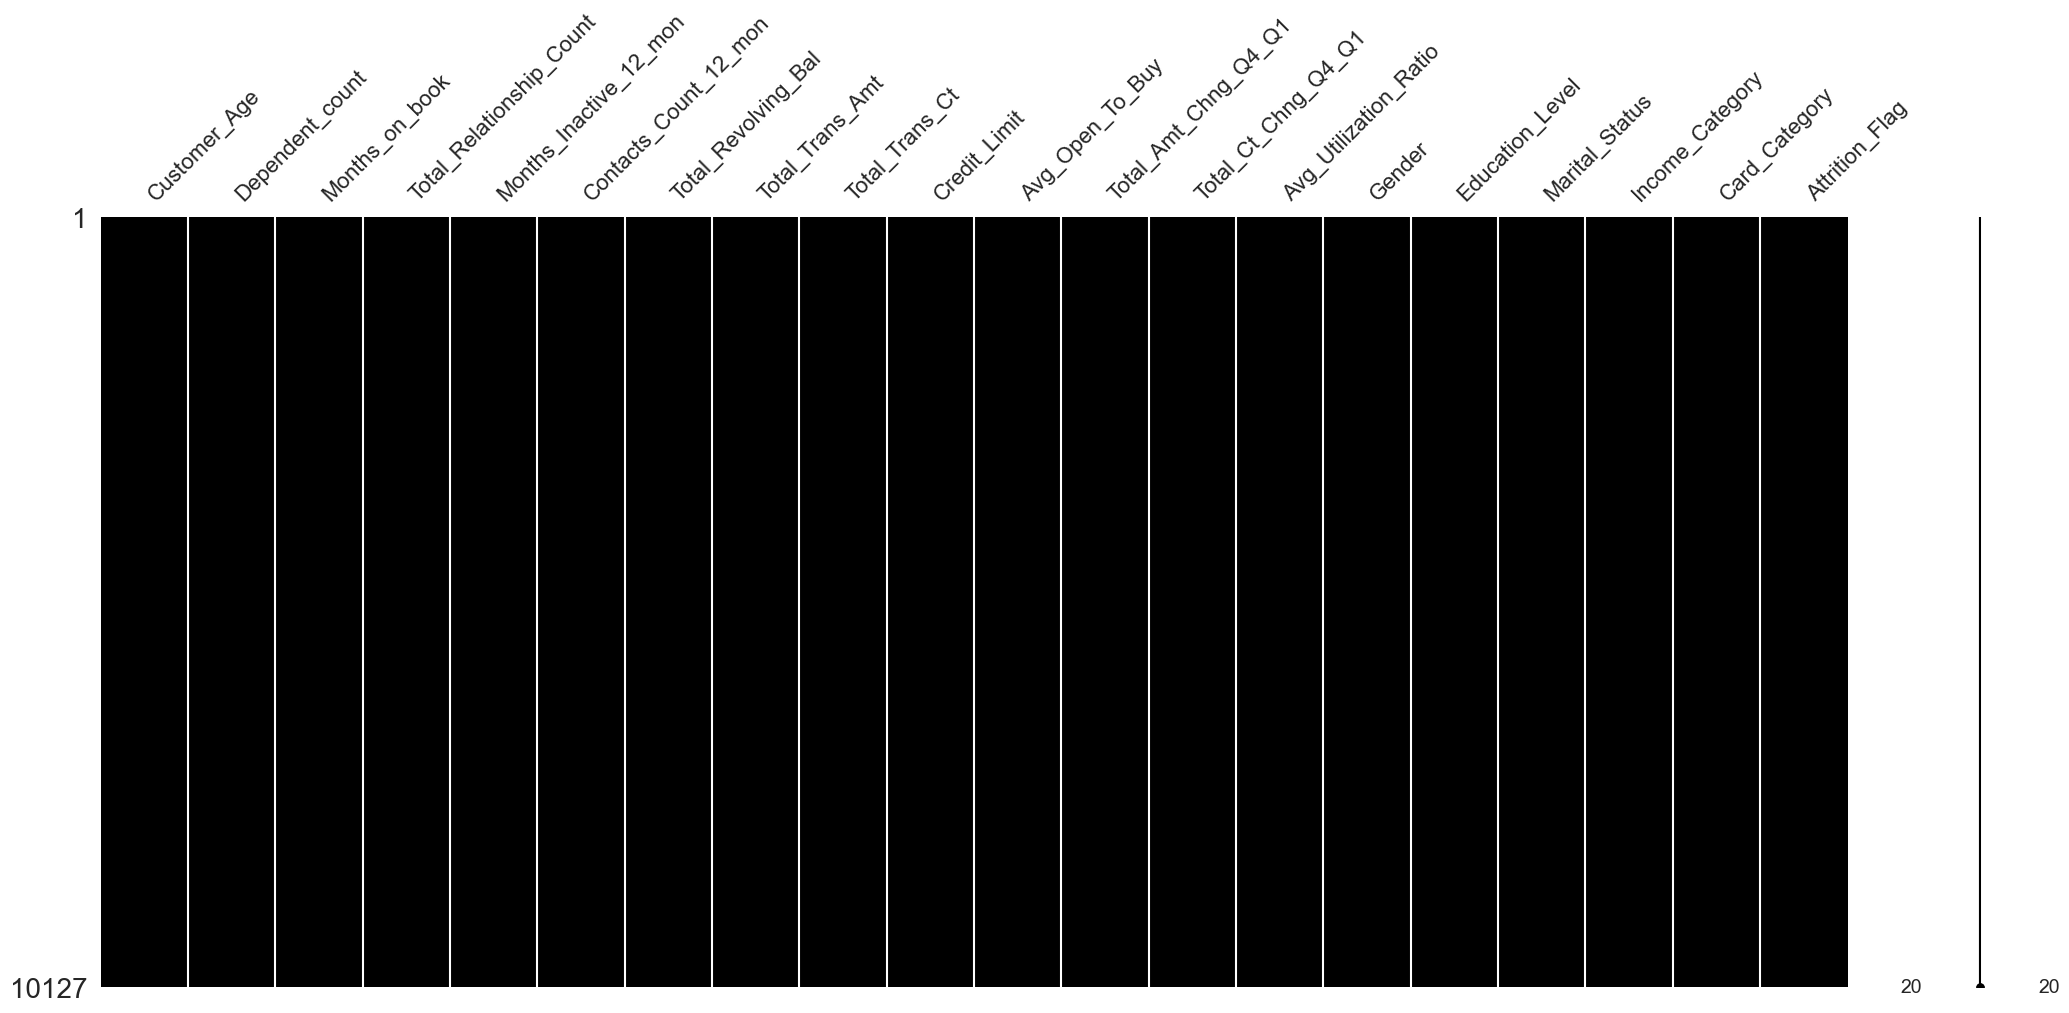

time: 391 ms (started: 2022-10-18 17:19:36 +03:00)


In [ ]:
msno.matrix(dataset_cleanup,color=(0,0,0))

Отсутствующих точек данных нет.

## Data deduplication (дедубликация данных)

Проверим датасет на наличие дубликатов экземпляров данных:

In [ ]:
dataset_cleanup[dataset_cleanup.duplicated()]

Empty DataFrame
Columns: [Customer_Age, Dependent_count, Months_on_book, Total_Relationship_Count, Months_Inactive_12_mon, Contacts_Count_12_mon, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct, Credit_Limit, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio, Gender, Education_Level, Marital_Status, Income_Category, Card_Category, Attrition_Flag]
Index: []

time: 16 ms (started: 2022-10-18 17:19:37 +03:00)


In [ ]:
print(dataset_cleanup.duplicated().sum())

0
time: 0 ns (started: 2022-10-18 17:19:37 +03:00)


Дубликатов данных нет.

## Categorical features (Категориальные признаки)

Следующие признаки датасета содержат категориальные переменные:
- "Gender", 
- "Education_Level", 
- "Marital_Status",
- "Income_Category", 
- "Card_Category"


### Gender (Пол клиента)

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
show_category_values(dataset_cleanup, ["Gender"])

Category names  Category count
Column name                               
Gender          ['F', 'M']               2

time: 0 ns (started: 2022-10-18 17:19:38 +03:00)


В признаке 2 категории, кардинальность низкая, несогласованного ввода нет.

### Education Level (Уровень образования)

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
show_category_values(dataset_cleanup, ["Education_Level"])

Category names  \
Column name                                                          
Education_Level  ['College', 'Doctorate', 'Graduate', 'High Sch...   

                 Category count  
Column name                      
Education_Level               7

time: 0 ns (started: 2022-10-18 17:19:39 +03:00)


В признаке 7 категорий, кардинальность низкая, несогласованного ввода нет.

### Marital Status (Семейный статус, брак)

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
show_category_values(dataset_cleanup, ["Marital_Status"])

Category names  Category count
Column name                                                                 
Marital_Status  ['Divorced', 'Married', 'Single', 'Unknown']               4

time: 16 ms (started: 2022-10-18 17:19:40 +03:00)


В признаке 4 категорий, кардинальность низкая, несогласованного ввода нет.

### Income Category (Доход) 

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
show_category_values(dataset_cleanup, ["Income_Category"])

Category names  \
Column name                                                          
Income_Category  ['$120K +', '$40K - $60K', '$60K - $80K', '$80...   

                 Category count  
Column name                      
Income_Category               6

time: 15 ms (started: 2022-10-18 17:19:41 +03:00)


В признаке 6 категорий, кардинальность низкая, несогласованного ввода нет.

### "Card Category" (Категория держателя карты) 

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
show_category_values(dataset_cleanup, ["Card_Category"])

Category names  Category count
Column name                                                          
Card_Category  ['Blue', 'Gold', 'Platinum', 'Silver']               4

time: 16 ms (started: 2022-10-18 17:19:42 +03:00)


В признаке 4 категорий, кардинальность низкая, несогласованного ввода нет.

### "Attrition flag" (Флаг оттока клиента) 

In [ ]:
show_category_values(dataset_cleanup, ["Attrition_Flag"])

Category names  Category count
Column name                                                               
Attrition_Flag  ['Attrited Customer', 'Existing Customer']               2

time: 16 ms (started: 2022-10-18 17:19:43 +03:00)


## Numerical features (Числовые признаки)

Следующие признаки датасета содержат числовые признаки (целочисленные, вещественные):

Целочисленные:

- "Customer_Age", 
- "Dependent_count", 
- "Months_on_book", 
- "Total_Relationship_Count", 
- "Months_Inactive_12_mon", 
- "Contacts_Count_12_mon", 
- "Total_Revolving_Bal",
- "Total_Trans_Amt", 
- "Total_Trans_Ct",

Вещественные:

- "Credit_Limit", 
- "Avg_Open_To_Buy", 
- "Total_Amt_Chng_Q4_Q1",
- "Total_Ct_Chng_Q4_Q1", 
- "Avg_Utilization_Ratio"

Проверку числовых признаков будем проводить по методу пограничных значений (глобальных экстремумов).

#### Check for inconsistent input (Проверка на несогласованный ввод данных)

In [ ]:
check_columns_boundaries(dataset_cleanup, integer_columns + real_columns)

Minimum       Maximum
Column name                                    
Customer_Age                 26.0     73.000000
Dependent_count               0.0      5.000000
Months_on_book               13.0     56.000000
Total_Relationship_Count      1.0      6.000000
Months_Inactive_12_mon        0.0      6.000000
Contacts_Count_12_mon         0.0      6.000000
Total_Revolving_Bal           0.0   2516.000000
Total_Trans_Amt             510.0  18480.000000
Total_Trans_Ct               10.0    139.000000
Credit_Limit               1438.0  34528.000000
Avg_Open_To_Buy               3.0  34528.000000
Total_Amt_Chng_Q4_Q1          0.0      3.396484
Total_Ct_Chng_Q4_Q1           0.0      3.714844
Avg_Utilization_Ratio         0.0      0.999023

time: 0 ns (started: 2022-10-18 17:19:45 +03:00)


Все числовые признаки имеют соответсвующий им допустимый диапазон.  Несогласованного ввод данных нет.

## Save the cleared data for future use (Сохраним очищенные данные для последующего использования)

Сохраним очищенные данные перед применение методов их кардинальной модификации. Это позволит нам вернуться к их исходному состоянию в случае повреждения данных.



In [ ]:
dataset_cleaned = dataset_cleanup.copy()
del dataset_cleanup

directory_fullpath = ""

dataset_cleaned.to_csv('dataset_cleaned.csv.zip', sep=',', encoding='utf-8', header=True, decimal=".", compression='zip')

del dataset_cleaned
gc.collect()

11292

time: 156 ms (started: 2022-10-18 17:19:49 +03:00)


Загрузим данные очищенные данные из файла:

In [ ]:
dataset_eda = pd.read_csv('dataset_cleaned.csv.zip', sep=',', encoding='utf-8', compression='zip', dtype=columns_and_types, index_col="CLIENTNUM", low_memory=False)

time: 15 ms (started: 2022-10-18 17:38:17 +03:00)


Проверим, все ли загрузилось нормально:

In [ ]:
dataset_eda.head()

Customer_Age  Dependent_count  Months_on_book  \
CLIENTNUM                                                  
768805383            45                3              39   
818770008            49                5              44   
713982108            51                3              36   
769911858            40                4              34   
709106358            40                3              21   

           Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                     
768805383                         5                       1   
818770008                         6                       1   
713982108                         4                       1   
769911858                         3                       4   
709106358                         5                       1   

           Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
CLIENTNUM                                                                
768805383                      3                  777             1144   
818770008                      2                  864             1291   
713982108                      0                    0             1887   
769911858                      1                 2517             1171   
709106358                      0                    0              816   

           Total_Trans_Ct  Credit_Limit  Avg_Open_To_Buy  \
CLIENTNUM                                                  
768805383              42       12688.0          11912.0   
818770008              33        8256.0           7392.0   
713982108              20        3418.0           3418.0   
769911858              20        3312.0            796.0   
709106358              28        4716.0           4716.0   

           Total_Amt_Chng_Q4_Q1  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
CLIENTNUM                                                                     
768805383              1.334961             1.625000               0.061005   
818770008              1.541016             3.714844               0.104980   
713982108              2.593750             2.332031               0.000000   
769911858              1.405273             2.332031               0.759766   
709106358              2.175781             2.500000               0.000000   

          Gender Education_Level Marital_Status Income_Category Card_Category  \
CLIENTNUM                                                                       
768805383      M     High School        Married     $60K - $80K          Blue   
818770008      F        Graduate         Single  Less than $40K          Blue   
713982108      M        Graduate        Married    $80K - $120K          Blue   
769911858      F     High School        Unknown  Less than $40K          Blue   
709106358      M      Uneducated        Married     $60K - $80K          Blue   

              Attrition_Flag  
CLIENTNUM                     
768805383  Existing Customer  
818770008  Existing Customer  
713982108  Existing Customer  
769911858  Existing Customer  
709106358  Existing Customer

time: 0 ns (started: 2022-10-18 17:38:19 +03:00)


# Exploratory Data Analysis (Исследовательский анализ данных)

Так как основная цель задания - обучение моделей, воспользуемся индексом взаимной информации чтобы выделить наиболее важные признаки из датасета. Это сократит время отбора наиболее значимых признаков, по которым мы и проведем исследовательский анализ данных.

## Mutual Information (Взаимная информация)

Отличным первым шагом является построение рейтинга с помощью **метрики полезности признака** - функции, измеряющей ассоциации между признаком и целью прогнозирования. Тогда станет возможным выбрать меньший набор наиболее полезных признаков для первоначальной разработки.

Метрика, которую я буду использовать, называется "взаимная информация". Взаимная информация во многом похожа на корреляцию, поскольку измеряет взаимосвязь между двумя величинами. Преимущество взаимной информации в том, что она может обнаружить *любой* вид взаимосвязи, в то время как корреляция обнаруживает только *линейные* взаимосвязи.

Взаимная информация - это отличная метрика общего назначения, особенно полезная в начале разработки признаков, когда еще не известно, какая модель будет использоваться в итоге. Она:
- проста в использовании и интерпретации,
- эффективна с точки зрения вычислений,
- теоретически обоснована,
- устойчива к переобучению, и,
- способна обнаружить любой вид взаимосвязи

### Mutual Information and What it Measures (Взаимная информация и что она измеряет)

Взаимная информация описывает отношения в терминах неопределенности. Взаимная информация (MI) между двумя величинами - это мера того, в какой степени знание одной величины уменьшает неопределенность в отношении другой. Если бы вы знали значение параметра, насколько более уверенно вы бы оценивали цель предсказания?

(Техническое примечание: то, что мы называем неопределенностью, измеряется с помощью величины из теории информации, известной как "энтропия". Энтропия переменной означает примерно следующее: "сколько в среднем вопросов "да-нет" нам понадобится, чтобы описать появление этой переменной". Чем больше вопросов нам придется задать, тем более неопределенной должна быть переменная. Взаимная информация - это количество вопросов, на которые, как мы ожидаем, функция ответит о цели предсказания).

### Interpreting Mutual Information Scores (Интерпретация оценок взаимной информации)

Наименьшая возможная взаимная информация между величинами равна 0,0. Когда MI равен нулю, величины независимы: ни одна из них ничего не может рассказать о другой. И наоборот, в теории не существует верхней границы того, каким может быть MI. Однако на практике значения выше 2,0 или около того встречаются редко. (Взаимная информация - это логарифмическая величина, поэтому она увеличивается очень медленно).

Следующий рисунок даст представление о том, как значения MI соответствуют виду и степени связи признака с целью предсказания.

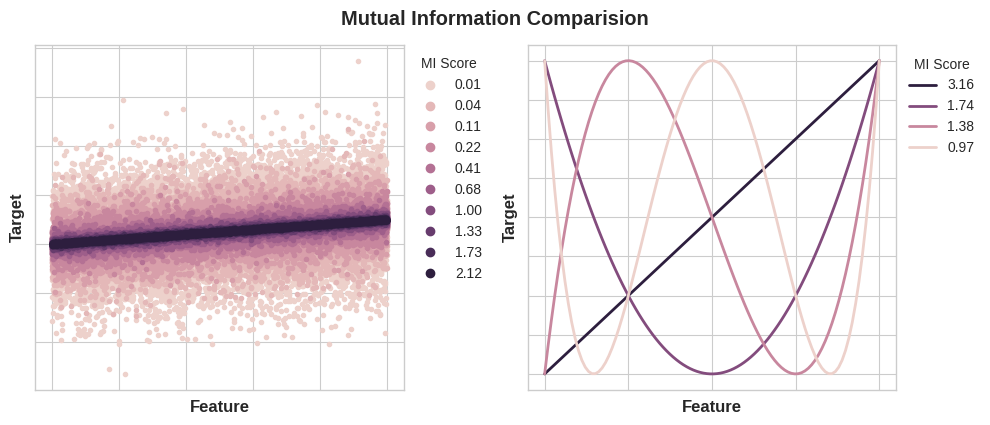

***Рисунок слева***: Взаимная информация увеличивается по мере того, как зависимость между признаком и целью прогнозирования становится более тесной.    
***Рисунок справа***: Взаимная информация может отражать любой вид связи (не только линейную, как корреляция).

Вот некоторые моменты, которые следует помнить при применении взаимной информации:

- MI может помочь вам понять ***относительный потенциал*** параметра как предиктора цели предсказания, если рассматривать его сам по себе.
- Возможно, что признак очень информативен при взаимодействии с другими признаками, но не так информативен сам по себе. MI ***не может обнаружить взаимодействие*** между признаками. Это ***неизмеримая*** метрика.
- ***Фактическая*** полезность признака ***зависит от модели, с которой он используется***. Признак полезен только в той степени, в какой его связь с целью прогноза может быть изучена вашей моделью. Если признак имеет высокий показатель MI, это еще не значит, что ваша модель сможет что-то сделать с этой информацией. Возможно, вам придется сначала преобразовать признак, чтобы выявить связь.

### Calculating the mutual information index for our dataset (Вычисление индекса взаимной информации для нашего набора данных)

Алгоритм scikit-learn для MI обрабатывает дискретные признаки иначе, чем непрерывные. Следовательно, нам необходимо указать ему, какие из них являются дискретными. Как правило, все, что ***имеет*** тип `float`, ***не*** является дискретным признаком. Категориальные признаки (имеющие тип данных  `dtype` `object` или `categorial`) можно рассматривать как дискретные, применив к ним кодировку с помощью метки (например, порядковое кодирование). Проверим какие признаки из нашего набора данных являются дискретными:

In [ ]:
dataset_eda_mi = dataset_eda.copy()

# Кодирование с помощью меток для категориальных признаков
for colname in dataset_eda_mi.select_dtypes("category"):
    dataset_eda_mi[colname], _ = dataset_eda_mi[colname].factorize()

X = dataset_eda_mi.copy()
y = X.pop("Attrition_Flag")

discrete_features = X.dtypes == int

time: 16 ms (started: 2022-10-18 17:38:23 +03:00)


In [ ]:
X.dtypes

Customer_Age                   int8
Dependent_count                int8
Months_on_book                 int8
Total_Relationship_Count       int8
Months_Inactive_12_mon         int8
Contacts_Count_12_mon          int8
Total_Revolving_Bal           int16
Total_Trans_Amt               int16
Total_Trans_Ct                int16
Credit_Limit                float16
Avg_Open_To_Buy             float16
Total_Amt_Chng_Q4_Q1        float16
Total_Ct_Chng_Q4_Q1         float16
Avg_Utilization_Ratio       float16
Gender                        int64
Education_Level               int64
Marital_Status                int64
Income_Category               int64
Card_Category                 int64
dtype: object

time: 0 ns (started: 2022-10-18 17:38:23 +03:00)


In [ ]:
discrete_features

Customer_Age                False
Dependent_count             False
Months_on_book              False
Total_Relationship_Count    False
Months_Inactive_12_mon      False
Contacts_Count_12_mon       False
Total_Revolving_Bal         False
Total_Trans_Amt             False
Total_Trans_Ct              False
Credit_Limit                False
Avg_Open_To_Buy             False
Total_Amt_Chng_Q4_Q1        False
Total_Ct_Chng_Q4_Q1         False
Avg_Utilization_Ratio       False
Gender                      False
Education_Level             False
Marital_Status              False
Income_Category             False
Card_Category               False
dtype: bool

time: 0 ns (started: 2022-10-18 17:38:23 +03:00)


In [ ]:
dataset_eda_mi.head()

Customer_Age  Dependent_count  Months_on_book  \
CLIENTNUM                                                  
768805383            45                3              39   
818770008            49                5              44   
713982108            51                3              36   
769911858            40                4              34   
709106358            40                3              21   

           Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                     
768805383                         5                       1   
818770008                         6                       1   
713982108                         4                       1   
769911858                         3                       4   
709106358                         5                       1   

           Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
CLIENTNUM                                                                
768805383                      3                  777             1144   
818770008                      2                  864             1291   
713982108                      0                    0             1887   
769911858                      1                 2517             1171   
709106358                      0                    0              816   

           Total_Trans_Ct  Credit_Limit  Avg_Open_To_Buy  \
CLIENTNUM                                                  
768805383              42       12688.0          11912.0   
818770008              33        8256.0           7392.0   
713982108              20        3418.0           3418.0   
769911858              20        3312.0            796.0   
709106358              28        4716.0           4716.0   

           Total_Amt_Chng_Q4_Q1  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
CLIENTNUM                                                                     
768805383              1.334961             1.625000               0.061005   
818770008              1.541016             3.714844               0.104980   
713982108              2.593750             2.332031               0.000000   
769911858              1.405273             2.332031               0.759766   
709106358              2.175781             2.500000               0.000000   

           Gender  Education_Level  Marital_Status  Income_Category  \
CLIENTNUM                                                             
768805383       0                0               0                0   
818770008       1                1               1                1   
713982108       0                1               0                2   
769911858       1                0               2                1   
709106358       0                2               0                0   

           Card_Category  Attrition_Flag  
CLIENTNUM                                 
768805383              0               0  
818770008              0               0  
713982108              0               0  
769911858              0               0  
709106358              0               0

time: 0 ns (started: 2022-10-18 17:38:24 +03:00)


Scikit-learn имеет две метрики взаимной информации в модуле `feature_selection`: одна для реально-значимых целей предсказания (`mutual_info_regression`) и одна для категориальных целей предсказания(`mutual_info_classif`). Наша цель прогнозирования `Attrition_Flag`, является категориальной целью предсказания.

In [ ]:
mi_scores = make_mi_scores(X, y, discrete_features)

# Выведем несколько признаков с их оценками MI
mi_scores[::3]  

Total_Trans_Amt             0.157569
Total_Revolving_Bal         0.082996
Contacts_Count_12_mon       0.022185
Total_Relationship_Count    0.012511
Education_Level             0.004800
Marital_Status              0.002207
Card_Category               0.000000
Name: MI Scores, dtype: float64

time: 563 ms (started: 2022-10-18 17:38:24 +03:00)


А теперь гистограмма, чтобы было легче сравнивать:

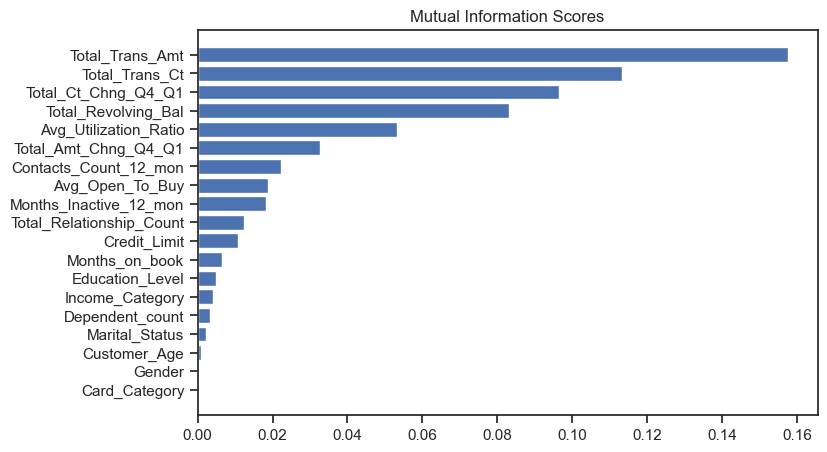

time: 187 ms (started: 2022-10-18 17:38:25 +03:00)


In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Intermediate results (промежуточные выводы)

В соответствии с полученным результатом стоит обратить наибольшеее внимание на следующие признаки:    
- `Total_Trans_Amt` - Общая сумма транзакций (за последние 12 месяцев).
- `Total_Trans_Ct` - Общее количество транзакций (за последние 12 месяцев).
- `Total_Ct_Chng_Q4_Q1` - Изменение количества транзакций (4 квартал по сравнению с 1 кварталом).
- `Total_Revolving_Bal` - Общий возобновляемый остаток по кредитной карте.
- `Avg_Utilization_Ratio` - Средний коэффициент использования карты.
- `Total_Amt_Chng_Q4_Q1` - Изменение суммы транзакций (4 квартал по сравнению с 1 кварталом).
- `Contacts_Count_12_mon` - Количество неактивных месяцев за последние 12 месяцев.
- `Months_Inactive_12_mon` - Количество неактивных месяцев за последние 12 месяцев.
- `Avg_Open_To_Buy` - Открытая для покупки кредитная линия (среднее значение за последние 12 месяцев).
- `Total_Relationship_Count` - Общее количество продуктов, имеющихся у клиента.
- `Credit_Limit` - Лимит по кредитной карте.
- `Gender` - пол заёмщика


## Матрица диаграмм рассеяния (числовые параметры)

Матрица диаграмм рассеяния отвечает на следующие вопросы:
- Существуют ли парные связи между различными переменными? И если есть взаимосвязи, то каков характер этих взаимосвязей?
- Есть ли в наборе данных какие-либо выбросы?
- Имеется ли в наборе данных кластеризация по группам на основе определенной переменной?

Визуализируем наши данные с помощью матрицы диаграмм рассеивания:Возьмем первые 8 признаков описывающие максимальную вариантивность датасета.

Построим матрицу диаграм рассеивания для первых 9 признаков:

<Figure size 1600x900 with 0 Axes>

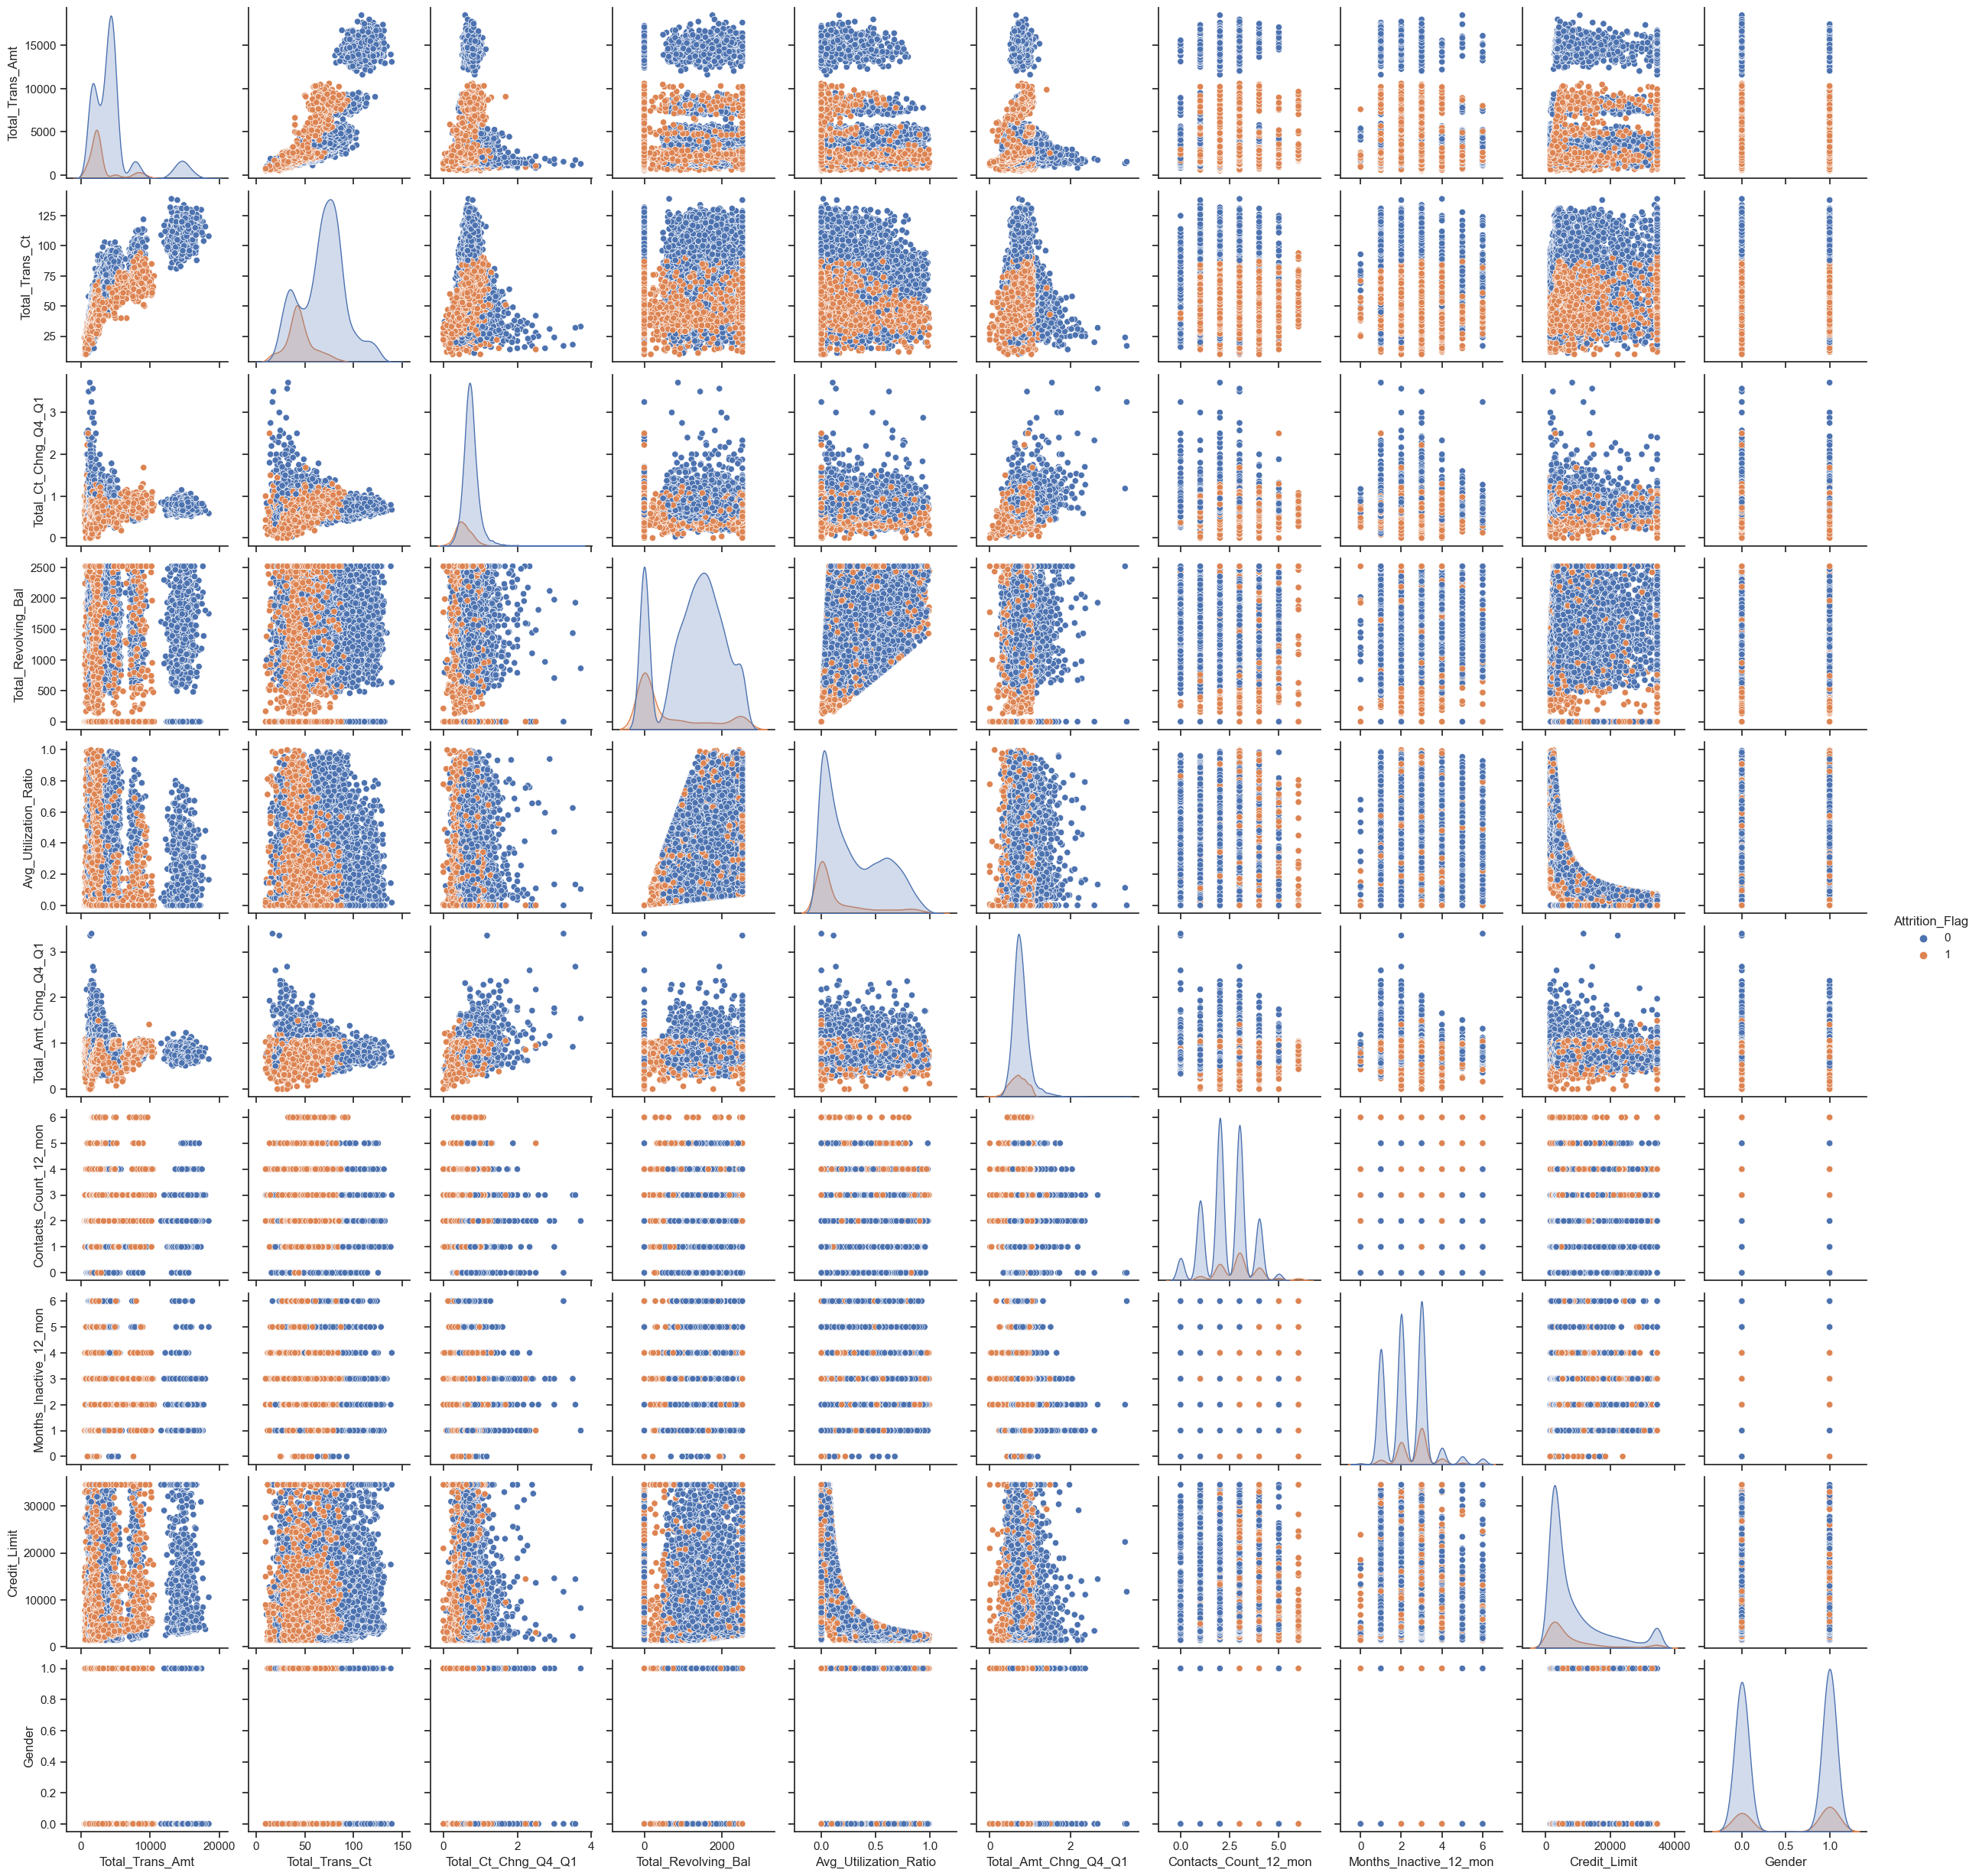

In [ ]:
plt.figure(figsize=(16,9))

sns.pairplot(dataset_eda_mi,
             x_vars=["Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Total_Revolving_Bal", "Avg_Utilization_Ratio", "Total_Amt_Chng_Q4_Q1", "Contacts_Count_12_mon", "Months_Inactive_12_mon", "Credit_Limit", "Gender"],
             y_vars=["Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Total_Revolving_Bal", "Avg_Utilization_Ratio", "Total_Amt_Chng_Q4_Q1", "Contacts_Count_12_mon", "Months_Inactive_12_mon", "Credit_Limit", "Gender"], 
             height=2.5, 
             hue="Attrition_Flag")

plt.savefig("pairplot.png", format="png")
plt.show()

#### Intermediate results (промежуточные выводы)

Анализируя матрицу диаграмм рассеяния можно сделать следующие выводы:
1. На графике присутсвуют четкие кластеры по цели прогнозирования. Следовательно признаки выбраны корректно. 
Взаимосвязи пар параметров так же присутсвуют.
2. Кластеризация наблюдается в большинстве пар признаков.
3. Большинство клиентов закрывающих счета совершали небольшое количество транзакций на приемущественно небольшие суммы 
(пара признаков: `Total_Trans_Amt` и `Total_Trans_Ct`).
4. Закрывающие счета клиенты перестают пользоваться кредитной картой либо пользуются ей реже (признак `Total_Amt_Chng_Q4_Q1`).
5. Размер кредитного лемита почти не влияет на оттток клиентов банка (признак `Credit_Limit`).

## Search for outliers in the data graphically (Поиск выбросов в данных графическим способом)

Проверим наиболее полезные признаки на наличие выборосов с помощью диаграммы boxplot (ящик с усами). При рассмотрении диаграммы boxplot выброс определяется как точка данных, которая находится за пределами усов квадратной диаграммы.

### Total amount of transactions (Общая сумма транзакций, за последние 12 месяцев)

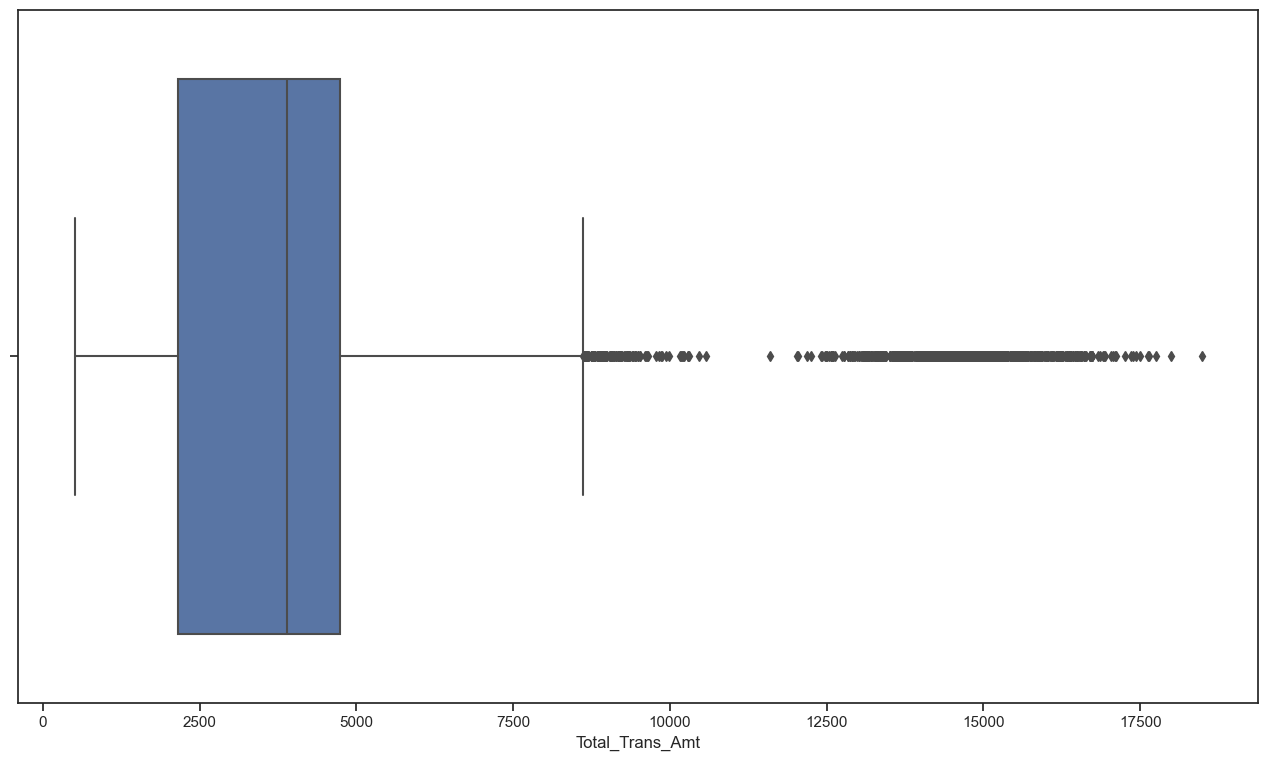

time: 78 ms (started: 2022-10-18 17:38:32 +03:00)


In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(x=dataset_eda_mi["Total_Trans_Amt"])
plt.show()

Судя по графику в признаке `Total_Trans_Amt` пирисутствуют выбросы.

### The total number of transactions, in the last 12 months (Общее количество транзакций, за последние 12 месяцев).

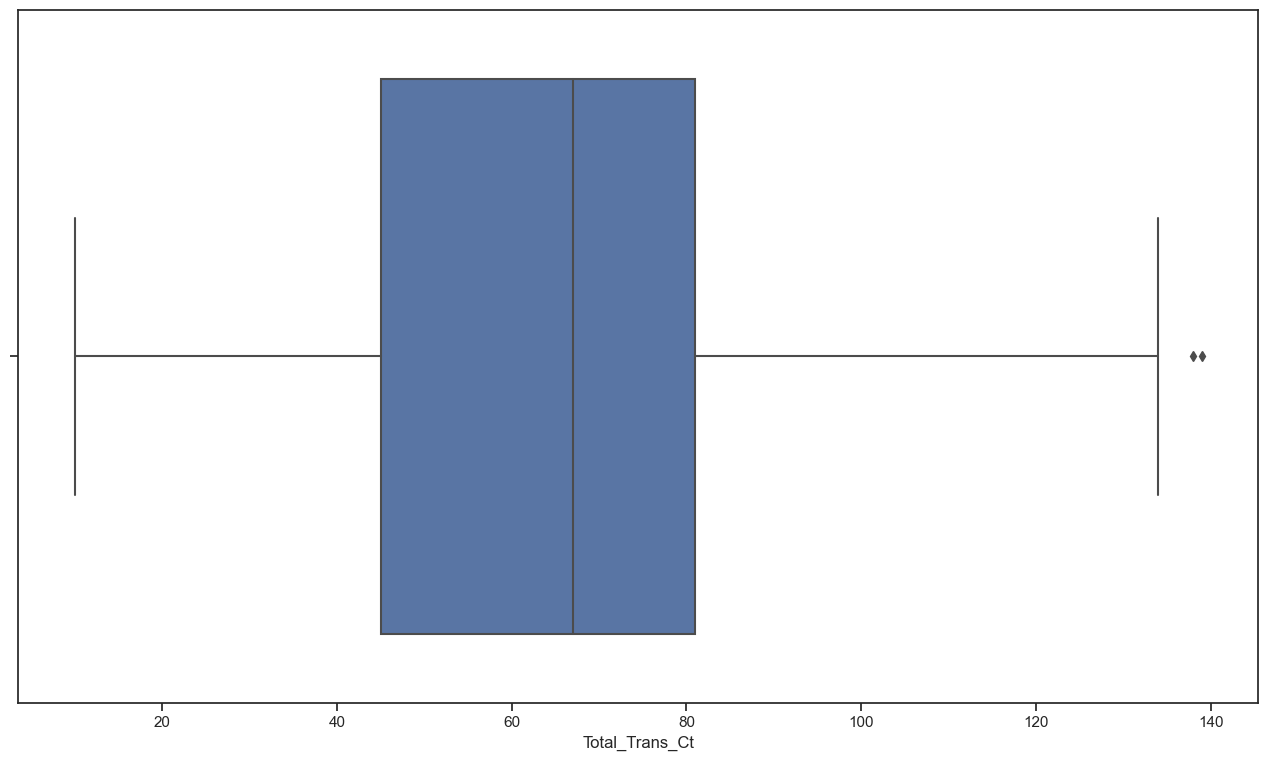

time: 78 ms (started: 2022-10-18 17:38:33 +03:00)


In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(x=dataset_eda_mi["Total_Trans_Ct"])
plt.show()

В признаке `Total_Trans_Ct` выбросов мало.

### Change in the number of transactions, Q4 compared to Q1 (Изменение количества транзакций, 4 квартал по сравнению с 1 кварталом). 

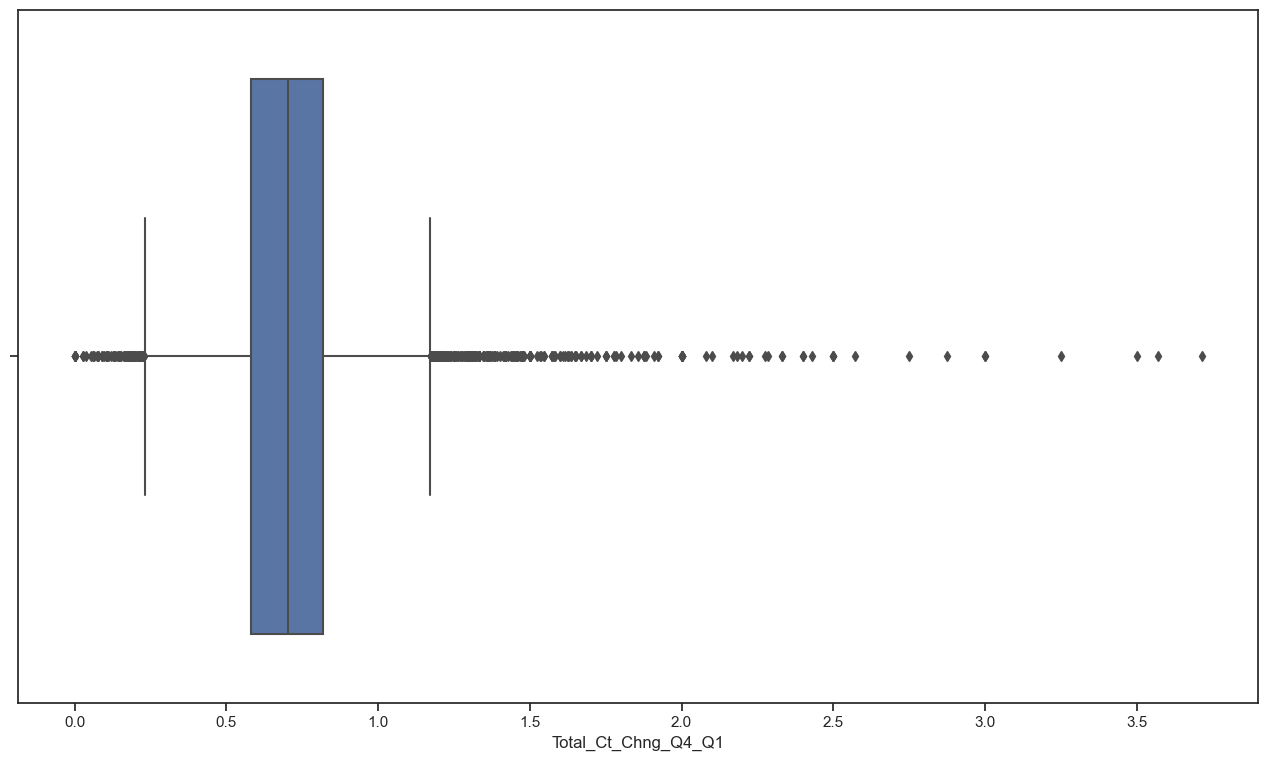

time: 78 ms (started: 2022-10-18 17:38:34 +03:00)


In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(x=dataset_eda_mi["Total_Ct_Chng_Q4_Q1"])
plt.show()

Признак `Total_Ct_Chng_Q4_Q1` содержит немало выбросов.

### Intermediate results (промежуточные выводы)

В нашем наборе данных присутствуют выбросы, что может негативно сказаться не качестве модели.

## Checking class balance (Проверка баланса классов)

В задачах классификаци для получения качественной модели необходимы качественные данные. Важным признаком качества датасета является баланс классов. Проверим балланс классов в нашем датасете:

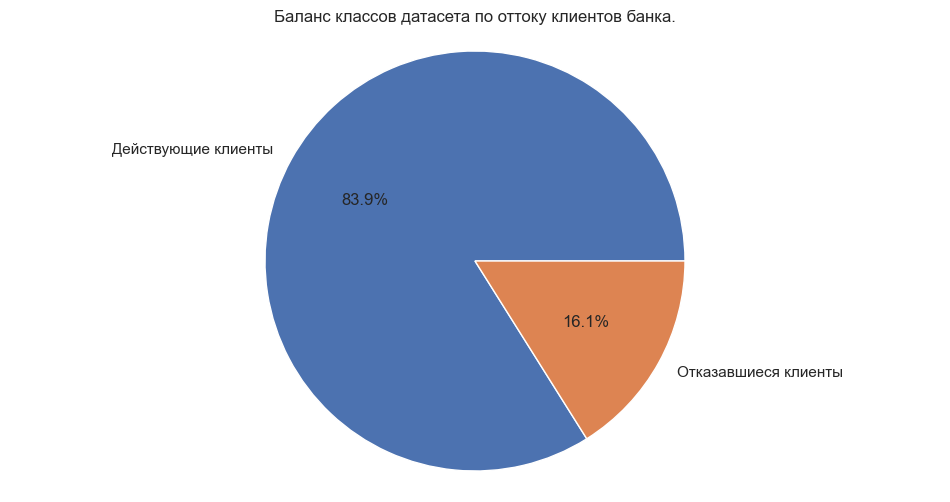

time: 78 ms (started: 2022-10-18 17:38:37 +03:00)


In [ ]:
# Проверка баланса классов
plt.figure(figsize=(12,6))

plt.pie(dataset_eda_mi.Attrition_Flag.value_counts(), 
        labels=['Действующие клиенты', 'Отказавшиеся клиенты'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title("Баланс классов датасета по оттоку клиентов банка.")

plt.show()

### Intermediate results (промежуточные выводы)

В нашем датасете серьёзный дизбаланс классов. Необходима аугментация данных.

# Baseline (базовая модель)

В качестве базовой модели будем использовать Cattboost c параметрами по умолчанию. В качестве базового датасета будем использовать данные подготовленные на предыдущем этапе.

In [ ]:
dataset_baseline = dataset_eda_mi.copy()

# del dataset_eda_mi
# gc.collect()

time: 15 ms (started: 2022-10-18 17:38:39 +03:00)


## Selecting data for modeling (Выбор данных для моделирования)

### Selecting a prediction target (Выбор цели прогноза)

In [ ]:
y = dataset_baseline[taget_column]

time: 0 ns (started: 2022-10-18 17:38:41 +03:00)


In [ ]:
y.head()

Attrition_Flag
CLIENTNUM                
768805383               0
818770008               0
713982108               0
769911858               0
709106358               0

time: 16 ms (started: 2022-10-18 17:38:41 +03:00)


### Select model features (Выбор параметров модели)

In [ ]:
X = dataset_baseline.drop(taget_column, axis=1)

time: 0 ns (started: 2022-10-18 17:38:42 +03:00)


In [ ]:
X.head()

Customer_Age  Dependent_count  Months_on_book  \
CLIENTNUM                                                  
768805383            45                3              39   
818770008            49                5              44   
713982108            51                3              36   
769911858            40                4              34   
709106358            40                3              21   

           Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                     
768805383                         5                       1   
818770008                         6                       1   
713982108                         4                       1   
769911858                         3                       4   
709106358                         5                       1   

           Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
CLIENTNUM                                                                
768805383                      3                  777             1144   
818770008                      2                  864             1291   
713982108                      0                    0             1887   
769911858                      1                 2517             1171   
709106358                      0                    0              816   

           Total_Trans_Ct  Credit_Limit  Avg_Open_To_Buy  \
CLIENTNUM                                                  
768805383              42       12688.0          11912.0   
818770008              33        8256.0           7392.0   
713982108              20        3418.0           3418.0   
769911858              20        3312.0            796.0   
709106358              28        4716.0           4716.0   

           Total_Amt_Chng_Q4_Q1  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
CLIENTNUM                                                                     
768805383              1.334961             1.625000               0.061005   
818770008              1.541016             3.714844               0.104980   
713982108              2.593750             2.332031               0.000000   
769911858              1.405273             2.332031               0.759766   
709106358              2.175781             2.500000               0.000000   

           Gender  Education_Level  Marital_Status  Income_Category  \
CLIENTNUM                                                             
768805383       0                0               0                0   
818770008       1                1               1                1   
713982108       0                1               0                2   
769911858       1                0               2                1   
709106358       0                2               0                0   

           Card_Category  
CLIENTNUM                 
768805383              0  
818770008              0  
713982108              0  
769911858              0  
709106358              0

time: 15 ms (started: 2022-10-18 17:38:42 +03:00)


In [ ]:
X.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Credit_Limit', 'Avg_Open_To_Buy',
       'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

time: 16 ms (started: 2022-10-18 17:38:43 +03:00)


## Dividing the dataset into training and test samples (Разделение датасета на тренировочную и тестовую выборки)

Разделим тренировочную часть датасета на тренировочную и тестовую выборки без аугментации данных:

In [ ]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.3, random_state=1, shuffle=True, stratify=y)

X_train_base.head()

Customer_Age  Dependent_count  Months_on_book  \
CLIENTNUM                                                  
755593983            50                1              43   
717825033            50                0              36   
712586583            26                0              13   
772539558            65                0              55   
771852483            46                3              35   

           Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                     
755593983                         6                       1   
717825033                         3                       3   
712586583                         6                       3   
772539558                         3                       3   
771852483                         6                       3   

           Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
CLIENTNUM                                                                
755593983                      2                    0             3873   
717825033                      2                 2499             4509   
712586583                      4                 1101             2152   
772539558                      0                    0             4623   
771852483                      4                    0             3343   

           Total_Trans_Ct  Credit_Limit  Avg_Open_To_Buy  \
CLIENTNUM                                                  
755593983              72        7984.0           7984.0   
717825033              80        5444.0           2944.0   
712586583              50        1643.0            542.0   
772539558              65        2022.0           2022.0   
771852483              77        4928.0           4928.0   

           Total_Amt_Chng_Q4_Q1  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
CLIENTNUM                                                                     
755593983              1.032227             0.673828               0.000000   
717825033              0.468018             0.666992               0.458984   
712586583              0.712891             0.470947               0.669922   
772539558              0.579102             0.547852               0.000000   
771852483              1.018555             0.638184               0.000000   

           Gender  Education_Level  Marital_Status  Income_Category  \
CLIENTNUM                                                             
755593983       1                1               0                5   
717825033       0                3               3                0   
712586583       1                1               1                3   
772539558       1                4               1                1   
771852483       0                1               1                2   

           Card_Category  
CLIENTNUM                 
755593983              0  
717825033              0  
712586583              0  
772539558              0  
771852483              0

time: 47 ms (started: 2022-10-18 17:38:46 +03:00)


## Gradient boosting (Градиентный бустинг)

Для решения задачи классификации будем использовать градиентный бустинг. Это метаалгоритм который строит ансамбль базовых алгоритмов машинного обучения для повышения эффективности.

Основные приемущества градиентного бустинга:
- лучшее решение для разнородных данных,
- легкость в освоении,
- Хорошо работает на малых обьемах даных.

### CatBoost

CatBoost - это алгоритм машинного обучения, который использует градиентный бустинг на деревьях решений.

Основные приемущества CatBoost:
- поддержка категориальных признаков,
- технология Ordered boosting для борьбы с переобучением,
- хорошее качество с параметрами по умолчанию
- и т. д.

Полезные параметры модели:
- `eval_set` - набор данных для оптимизации гиперпараметров, обнаружения переобучения.
- `eval_metric` - метрика, используемая для обнаружения переобучения (если заданна) и выбора лучшей модели (если заданна).
- `iterations` - Максимальное количество деревьев, которые могут быть построены при решении задач машинного обучения.
- `learning_rate` - Скорость обучения. Используется для уменьшения шага градиента.   
- `random_seed` - задает параметр `random_seed` используемый для обучения. Используется для обеспечения воспроизводимости результата.    
- `depth` - глубина дерева.
- `score_function` - Тип оценки, используемый для выбора следующего разделения при построении дерева.
- `task_type` - Тип блока обработки, который будет использоваться для обучения (CPU или GPU).
- `devices` - Идентификаторы устройств GPU, которые будут использоваться для обучения (индексы основаны на нулях). Можно определить с помощью команды `nvidia-smi`.    
- `use_best_model` - использование наилучшей модели полученной в процессе обучения. Работает только совместно с параметром `eval_set`. Отбрасывает ненужные итерации (дополнительные ненужные деревья) оставляя только наиболее качественную (не переобучившуюся) модель. По умолчанию включен.


In [ ]:
categorical_columns_idx = [14, 15, 16, 17, 18]

# Создадим пулы тренировочных и тестовых данных, укажем индексы категориальных признаков.
train_data = Pool(data=X_train_base, label=y_train_base, cat_features=categorical_columns_idx)

test_data = Pool(data=X_test_base, label=y_test_base, cat_features=categorical_columns_idx)


# Модель с базовыми настройками.
model = CatBoostClassifier(iterations =  600, 
                           learning_rate = 0.1, 
                           loss_function = 'Logloss', 
                           custom_loss =["Accuracy"],  
                           verbose = False,
                           early_stopping_rounds = 20,  # Предотвращаем переобучение, если на валидационном множестве ухудшается ошибка на протяжении 20 итераций.
                           use_best_model = True,       # Обрезаем модель до наилучшей.
                           eval_metric = "F1",          # Используем для подрезки модели метрику F1
                           task_type = 'GPU',
                           devices='0:1'
                           )

# Подгоним модель к тренировочным данным
model.fit(train_data, verbose=False, plot=False)

# Получим предсказание и выведем метрики
prediction = model.predict(X_test_base)

print("Лучшая итерация:", model.best_iteration_)
print("Количество деревьев в модели:", model.tree_count_)

print(classification_report(y_test_base, prediction))

Лучшая итерация: 136
Количество деревьев в модели: 137
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2551
           1       0.95      0.91      0.93       488

    accuracy                           0.98      3039
   macro avg       0.97      0.95      0.96      3039
weighted avg       0.98      0.98      0.98      3039

time: 8.08 s (started: 2022-10-18 17:42:54 +03:00)


# Feature Engineering (Инженерия параметров)

## Dimensionality reduction, feature selection based on the mutual information score (Снижение размерности, выбор признаков на основе оценки взаимной информации)

В разделе "Исследовательский анализ данных" было произведено вычисление оценки взаимной информации для признаков датасета. Выберем минимально возможный набор признаков и проверим, достаточно ли данной информации для обучения модели того же качества, что и базовая модель (baseline). 

In [ ]:
# Признаки выбранные по оценке взаимной информации
categorical_columns_mi = ["Gender"]

integer_columns_mi = ["Customer_Age", "Dependent_count", "Months_on_book", 
                      "Total_Relationship_Count", "Months_Inactive_12_mon", 
                      "Contacts_Count_12_mon", "Total_Revolving_Bal", 
                      "Total_Trans_Amt", "Total_Trans_Ct"]

real_columns_mi = ["Credit_Limit", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", 
                   "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]

mi_features = integer_columns_mi + real_columns_mi + categorical_columns_mi

X_train_mi = X_train_base[mi_features]

X_test_mi = X_test_base[mi_features]

# Получим индекс категориального признака
categorical_columns_idx_mi = [X_train_mi.columns.get_loc("Gender")]

# Соберем тренировочную и валидационную часть, указав индекс категориального признака
train_data_mi = Pool(data=X_train_mi, label=y_train_base, cat_features=categorical_columns_idx_mi)
test_data_mi = Pool(data=X_test_mi, label=y_test_base, cat_features=categorical_columns_idx_mi)

# Модель с базовыми настройками.
model = CatBoostClassifier(iterations=600, 
                           learning_rate=0.1, 
                           loss_function='Logloss', 
                           custom_loss=["Accuracy"],  
                           verbose=False, 
                           use_best_model=True,
                           task_type = 'GPU',
                           devices='0:1')

# Подгоним модель к тренировочным данным
model.fit(train_data_mi, verbose=False, eval_set=test_data_mi)

# Получим предсказание и выведем метрики
prediction = model.predict(X_test_mi)

# print("Best model params:", model.get_params())
print(classification_report(y_test_base, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2551
           1       0.93      0.93      0.93       488

    accuracy                           0.98      3039
   macro avg       0.96      0.96      0.96      3039
weighted avg       0.98      0.98      0.98      3039

time: 17.2 s (started: 2022-10-18 17:43:56 +03:00)


### Intermediate results (промежуточные выводы)

Применение оценок взаимной инофрмации позволило сократить количество признаков датасета необходимое для обучения модели того же качества. Падение метрик качества не более 0.02, при этом удалось сократить датасет на 4 категориальных признака.

## Feature Importance (Важность признаков с точки зрения модели)

Посмотрим на важность признаков с точки зрения модели:

Text(0.5, 1.0, 'Важность признаков')

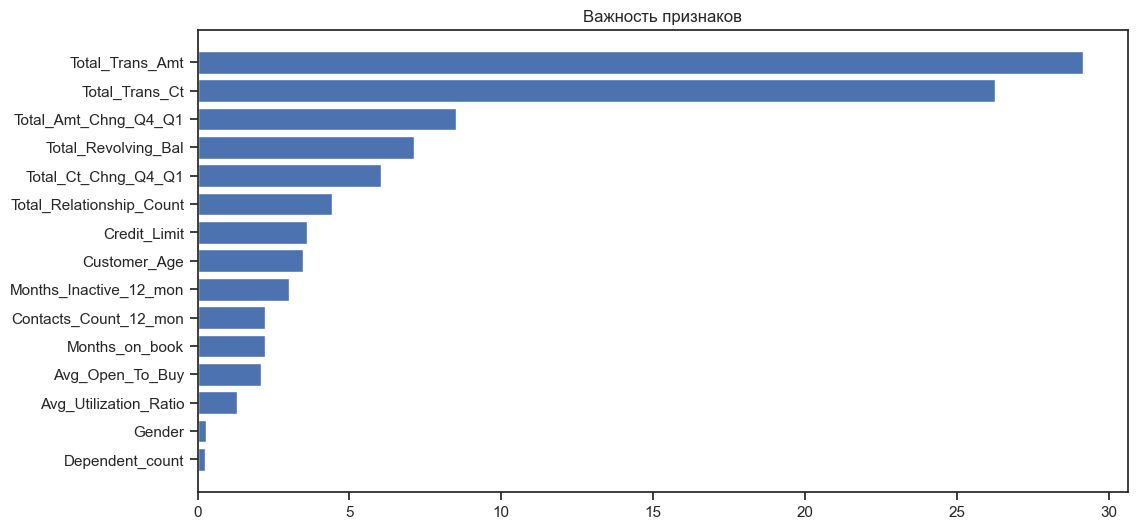

time: 156 ms (started: 2022-10-18 17:44:34 +03:00)


In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_mi.columns)[sorted_idx])
plt.title('Важность признаков')

Посмотрим на важность признаков на основе оценке взаимной информации еще раз:

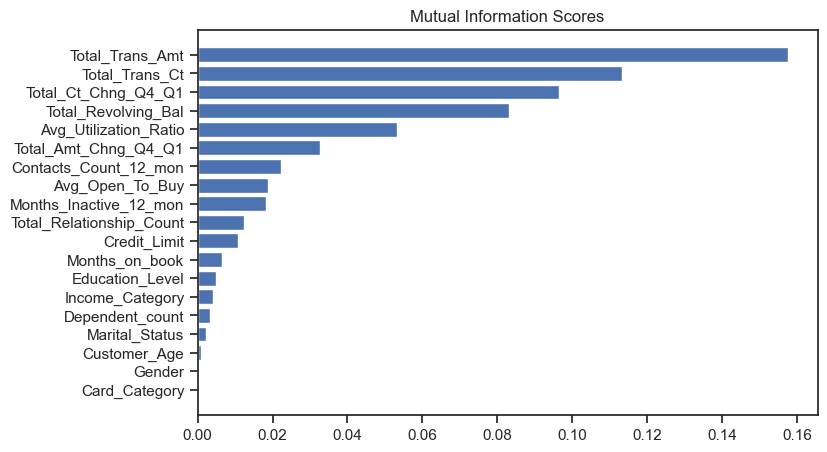

time: 172 ms (started: 2022-10-18 17:44:36 +03:00)


In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Intermediate results (промежуточные выводы)

Множество важных для модели признаков и множество признаков с высокой оценкой взаимной инофрмации практически совпадают, за исключением оценки их важности. Но в целом, наиболее важными оказались почти те же самые признаки. Различия не слишком значительные.

# Cross Validation of gradient boosting (Кросс-валидация градиентного бустинга) НЕ ИСПОЛЬЗУЕМ В РАБОТЕ!!!

ЭТО ПРОСТО ПРИМЕР! В РАБОТЕ ИСПОЛЬЗУЕТСЯ GREAD_SEARCH ВНУТРИ КОТОРОГО РЕАЛИЗОВАННА КРОСС-ВАЛИДАЦИЯ!!!

До текущего момента мы измеряли качество модели на тренировочной части датасета. Это не совсем корректно. Вполне возможно, что тестовая (валидационная) часть датасета может оказаться не репрезентативной. При применении нашей модели к другим данным может возникнуть ситуация при которой качество будет сильно отличаться. Эту проблему решает кросс-валидация.

Кросс-валидация это процесс обучения модели, при котором весь тренировочный датасет разбивается на части (folds). В первой итерации модель обучается на всех частях обучающей части датасета кроме первой части, первая часть используется для тестирования. На второй итерации модель обучается на всех частях тренировочной выборки кроме второй части. Вторая часть используется для тестирования. И так далее. Для этого используется функция `cv()`:

In [ ]:
from catboost import cv

# Отберем данные для модели, будем использовать весь датасет и только значимые признаки
X_cross_val = X[mi_features]
y_croos_val = y


# Зададим параметры модели
model_params = {
    "loss_function" : "Logloss",
    "iterations" : 500,
    "custom_loss" : "Accuracy",
    "random_seed" : 1,
    "learning_rate" : 0.01,
    "eval_metric" : "F1"  # метрика, по которой обрезаем модель.
}

# Настроим и запустим кросс-валидацию
cross_val = cv(
    params = model_params,	# Параметры модели
    pool = Pool(X, label=y, cat_features=categorical_columns_idx_mi),	# Данные, испотльзуемые для кросс-валидации
    fold_count = 5,	# Колличество чатсей данных используемых в кросс-валидации
    shuffle = True,	# Включим перемешивание данных
    partition_random_seed=0,	# seed используемый при перемешивании
    plot = False,	# Не рисовать график кривых обучения
    stratified=True,	# Стратификация (сохранять пропорцию классов, учитываем дизбаланс классов в датасете)
    verbose=False
)

Training on fold [0/5]

bestTest = 0.8925081433
bestIteration = 495

Training on fold [1/5]

bestTest = 0.8888888889
bestIteration = 491

Training on fold [2/5]

bestTest = 0.8974358974
bestIteration = 491

Training on fold [3/5]

bestTest = 0.8866666667
bestIteration = 498

Training on fold [4/5]

bestTest = 0.8972267537
bestIteration = 458

time: 8.09 s (started: 2022-10-18 17:45:25 +03:00)


Посмотрим на результаты кросс-валидации:

In [ ]:
cross_val.head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
0           0      0.647044     0.032481       0.647961      0.023190   
1           1      0.667237     0.023258       0.676189      0.008694   
2           2      0.655106     0.016796       0.660769      0.025378   
3           3      0.675607     0.016134       0.683056      0.014050   
4           4      0.679624     0.013937       0.686194      0.012386   

   test-Logloss-mean  test-Logloss-std  train-Logloss-mean  train-Logloss-std  \
0           0.680145          0.000279            0.680072           0.000363   
1           0.667276          0.000452            0.667128           0.000391   
2           0.655644          0.000668            0.655400           0.000951   
3           0.642586          0.000583            0.642293           0.001006   
4           0.629841          0.000615            0.629476           0.001262   

   test-Accuracy-mean  test-Accuracy-std  train-Accuracy-mean  \
0            0.898491           0.009120             0.899477   
1            0.906290           0.006194             0.908808   
2            0.905401           0.004728             0.906982   
3            0.911326           0.005103             0.913227   
4            0.912511           0.003855             0.914091   

   train-Accuracy-std  
0            0.004078  
1            0.004219  
2            0.007428  
3            0.004326  
4            0.002965

time: 16 ms (started: 2022-10-18 17:45:37 +03:00)


Определим наилучший результат:

In [ ]:
best_value = np.min(cross_val['test-Logloss-mean'])
best_iter = np.argmin(cross_val['test-Logloss-mean'])

print("Наилучший результат LogLoss score, стратифицированный: {:.8f} std: {:.8f} на шаге {}".format(
    best_value,
    cross_val['test-Logloss-std'][best_iter],
    best_iter
))

Наилучший результат LogLoss score, стратифицированный: 0.10371409 std: 0.00194589 на шаге 499
time: 0 ns (started: 2022-10-18 17:45:38 +03:00)


# Optimization of hyperparameters (Оптимизация гиперпараметров)

In [ ]:
grid = {'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': np.arange(1, 11, 1),
        'learning_rate': np.arange(0.01, 0.1, 0.01)}


classifier = CatBoostClassifier(iterations = 400,
                                random_seed = 1,
                                leaf_estimation_method = 'Newton',
                                custom_loss = ["Accuracy"],
                                verbose=False,
                                early_stopping_rounds = 20,
                                eval_metric = "F1",
                                task_type="GPU",
                                devices='0:1')

grid_search_result = classifier.grid_search(grid, train_data, cv=5, plot=False, verbose=False, 
                                            shuffle = True, stratified = True, )

print(grid_search_result['params'])

In [ ]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 10, 'learning_rate': 0.08}

time: 0 ns (started: 2022-10-19 00:39:30 +03:00)


# The final model (Итоговая модель)

In [ ]:
# Модель с базовыми настройками.
model = CatBoostClassifier(iterations =  600, 
                           learning_rate = 0.08, 
                           depth = 10,
                           l2_leaf_reg = 10,
                           loss_function = 'Logloss', 
                           custom_loss =["Accuracy"],  
                           verbose = False,
                           early_stopping_rounds = 20,  # Предотвращаем переобучение, если на валидационном множестве ухудшается ошибка на протяжении 20 итераций.
                           use_best_model = True,       # Обрезаем модель до наилучшей.
                           eval_metric = "F1",          # Используем для подрезки модели метрику F1
                           task_type = 'GPU',
                           devices='0:1',
                           
                           )

# Подгоним модель к тренировочным данным
model.fit(train_data, verbose=False, eval_set=test_data, plot=False)

# Получим предсказание и выведем метрики
prediction = model.predict(X_test_base)

print(classification_report(y_test_base, prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2551
           1       0.94      0.92      0.93       488

    accuracy                           0.98      3039
   macro avg       0.96      0.95      0.96      3039
weighted avg       0.98      0.98      0.98      3039

time: 33.3 s (started: 2022-10-19 00:38:57 +03:00)


# Final conclusions (Итоговые выводы)

1. Судя по результатам, ансамблевые методы отлично справляются с дисбалансом классов в наборе данных без применения аугментации. Кроме того, градиентный бустинг (Catboost) показал весьма высокий результат с минимальной предобработкой датасета.
2. Оценка взаимной информации помогает сократить количество признаков необходимых для обучения качественной модели. Кроме того в датасетах с большим набором признаков эта методика позволит существенно упростить все последующие этапы и снизить вычислительную ёмкость процесса разработки модели. Снижение затрат на предобработку не нужных данных для построения качественной модели тоже является существенным плюсом. Нет смысла разрабатывать такие признаки как уровень образования, категория карты и т. д., по причине их незначительного вклада в результат классификации.
3. Применение аугментации привело бы гипотетический к уменьшению количества деревьев в модели и более быстрой сходимости. Но в рамках целей этой работы я принял решение опустить этот этап. В реалльных условиях промышленной разработки не стоит исключать этот этап. Так как исключить его позволило именно применение ансамбля моделей (решающих деревьев). С более простыми алгоритмами так делать не стоит, качество классификации существенно ухудшится. 

# Additional materials (Дополнительные материалы)

Визуализация пропущенных значений:

- https://github.com/ResidentMario/missingno

Очистка датасета от выбросов с помощью Pandas:    

- https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
- https://neuraldatascience.io/5-eda/data_cleaning.html

Градиентный бустинг (Catboost):
- https://www.youtube.com/watch?v=xl1fwCza9C8&t=1s

Полезный блокнот по CatBoost (GreadSearch):
- https://catboost.ai/en/docs/features/visualization_jupyter-notebook
- https://catboost.ai/en/docs/concepts/python-reference_catboost_grid_search#output-format